## 0.Introduction
The purpose of this notebook is to find optimal  $L_2$, $L_3$, $d$ and $\alpha$ according to $L_1$, $D$ and $W$ in order for steering system to satisfy Ackermann condotion, which is shown in Fig2

<table>
    <tr>
        <th>
            <div id="fig1" >
                <img src="steeringParam.png" width="250"/>
            </div>
        </th>
        <th>
            <div id="fig2" >
                <img src="AckermannTurning.png" width="400"/>
            </div>
        </th>
    </tr>
    <tr>
        <th style="text-align:center" >Fig1.Rack and Pinion Steering System Parameters</td>
        <th style="text-align:center" >Fig2.Ackermann Steering System</td>
    </tr>
</table>




In [1]:
import numpy as np
from numpy import sin,cos,arcsin,arccos,tan,arctan,pi
from matplotlib import pyplot as plt
# from sympy import *
%matplotlib inline

In [2]:
D  = 1.600 #meter
W  = 2.650 #meter
L1 = 0.14  # assume that the length of Steering-Arm is fixed (or is designed beforehand) 

## 1.Ideal Values
Firstly, Let's calculate and illustrate ideal values for Ackermann steering condition:

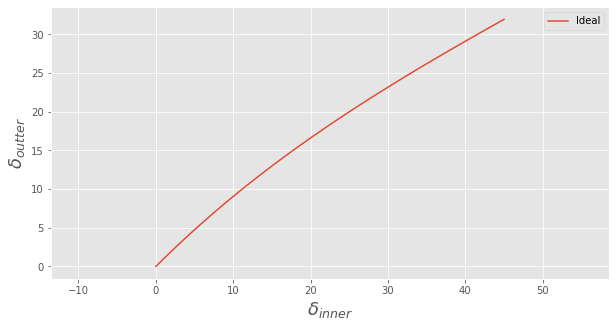

In [3]:
def outter_delta(inner_delta):
    return arctan( 1/(D/W+1/tan(inner_delta)) )

x = np.linspace(0.0001,45*pi/180,100)
y = outter_delta(x)
with plt.style.context("ggplot"):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.plot(x*180/pi,y*180/pi,label='Ideal')
    plt.xlabel(r'$\delta_{inner}$',fontsize=18)
    plt.ylabel(r'$\delta_{outter}$',fontsize=18)
    plt.axis('equal')
    plt.legend()
    plt.show()

In [4]:
import matplotlib.animation

%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

def rotate(arr,theta):
    R = np.array([[cos(theta),-sin(theta)],[sin(theta),cos(theta)]])
    return np.matmul(R,arr)
    
def tire(x0,y0,theta,draw_per_line=True):
    t = 0.15
    r = 0.5
    p = rotate(np.array([[-t/2,-t/2,t/2,t/2,-t/2],[r/2,-r/2,-r/2,r/2,r/2]]),theta)
    plt.plot(p[0]+x0,p[1]+y0,color = 'black')
    if draw_per_line:
        p = rotate(np.array([[-W/(sin(theta)+0.00001)-1.5,0],[0,0]]),theta)
        plt.plot(p[0]+x0,p[1]+y0,color='coral')
    plt.axis('equal')
    plt.axis('off')

def animate(t):
    plt.cla()
    inner_delta = (t+10)/40
    tire(-D/2,W/2,inner_delta)
    tire(-D/2,-W/2,0,False)
    tire(D/2,-W/2,0)
    tire(D/2,W/2,outter_delta(inner_delta))
    plt.ylim(-W,W)
    plt.xlim(-10,D/1.5)
    
matplotlib.animation.FuncAnimation(fig, animate, frames=15)

## 2.Rack and Pinion steering system design
Here, a class with helper functions is defiend. Using following cells you can tune steering system parameters so that it confirms ideal property.

In [5]:

class rack_pinion_steering_sys:
    table = []
    alpha = []
    L1 = L1
    L2 = []
    L3 = []
    d = []
    D = D
    theta_max = []
    phi2 = []
    def __init__(self, alpha =  17.5*pi/180, d = 0.2, L2 = 0.5):
        self.alpha = alpha
        self.d = d
        self.L2 = L2
        phi_0 = arcsin((d-L1*cos(alpha))/L2)
        self.L3 = self.D-2*(  L2*cos(phi_0) + L1*sin(alpha)  );
        self.theta_max = arccos(d/(L1+L2))
        self.phi2 = phi_0


    def get_states(self,delta):
        theta = delta + self.alpha
        phi = arcsin((self.d-self.L1*cos(theta))/self.L2)

        C = self.D - (self.L1*sin(theta)+self.L2*cos(phi)+self.L3)
        gamma = arccos((self.L1**2+self.L2**2-self.d**2-C**2)/(2*self.L1*self.L2))
        
        while True:
            phi2 = arcsin((self.d-self.L1*sin(gamma - self.phi2))/self.L2)
            if abs(phi2-self.phi2)<1e-10:
                self.phi2 = phi2
                break
            self.phi2 = phi2
            
        theta2 = arcsin((self.L2*cos(self.phi2)-C)/self.L1)
        delta2 = theta2 + self.alpha 

        return np.array([delta2,theta,phi,theta2,self.phi2])

    
    def get_y2(self,x):
        y2 = np.zeros_like(x)
        for i,xx in enumerate(x):
            y2[i],_,_,_,_ = self.get_states(xx)
        
        return y2

In [6]:
mySteer = rack_pinion_steering_sys()

<IPython.core.display.Javascript object>


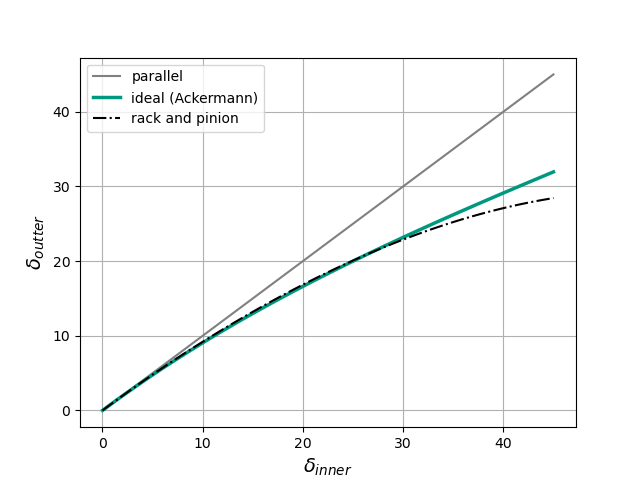

FloatSlider(value=17.5, continuous_update=False, description='$\\alpha$', max=25.0, min=-25.0, step=0.5)

IntSlider(value=20, continuous_update=False, description='$d$', max=30, min=-20)

IntSlider(value=50, continuous_update=False, description='$L_2$', max=70, min=10)

In [20]:
import ipywidgets as widgets
# import warnings
# warnings.filterwarnings("ignore")
%matplotlib notebook
x = np.linspace(0.0001,45*pi/180,100)
y = outter_delta(x)
y2 = mySteer.get_y2(x)
bluishGreen = [0,.60,.50];

%matplotlib notebook
with plt.style.context("default"):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(x*180/pi,x*180/pi,label='parallel',color='gray')
    main, = ax.plot(x*180/pi,y*180/pi,label='ideal (Ackermann)',color=bluishGreen,linewidth=2.5)
    mine, = ax.plot(x*180/pi,y2*180/pi,'-.',label='rack and pinion',color='k')
    ax.set_xlabel(r'$\delta_{inner}$',fontsize=14)
    ax.set_ylabel(r'$\delta_{outter}$',fontsize=14)
    ax.legend()
    ax.grid()
    
def update_plot(alpha,d=mySteer.d,L2=mySteer.L2):
    mySteer.__init__(alpha,d,L2)
    y2 = mySteer.get_y2(x)
    mine.set_ydata(y2*180/pi)
    fig.canvas.draw()
    

def fnc1(val):
    tmp = val['new']*pi/180
    update_plot(tmp,mySteer.d,mySteer.L2)    
def fnc2(val):
    tmp = val['new']/100.0
    update_plot(mySteer.alpha,tmp,mySteer.L2)
def fnc3(val):
    tmp = val['new']/100.0
    update_plot(mySteer.alpha,mySteer.d,tmp)

slider1 = widgets.FloatSlider(value=17.5, min=-25.0, max=25.0,step=0.5,description=r'$\alpha$', continuous_update=False)
slider2 = widgets.IntSlider(value=20, min=-20, max=30,description=r'$d$', continuous_update=False)
slider3 = widgets.IntSlider(value=50, min=10, max=70,description=r'$L_2$', continuous_update=False)
   
slider1.observe(fnc1, names="value")
slider2.observe(fnc2, names="value")
slider3.observe(fnc3, names="value")

display(slider1,slider2,slider3)

In [11]:
fig.savefig('ideal_rackPinion_plot.pdf')

In [40]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 300  
plt.ioff()
fig2,_ = plt.subplots()

L2,L3,d = mySteer.L2,mySteer.L3,mySteer.d

def draw_bars(theta,phi,theta2,phi2):
    X = np.array([-D/2])
    Y = np.array([W/2])
    X = np.append(X,X[-1]+L1*sin(theta))
    Y = np.append(Y,Y[-1]-L1*cos(theta))
    X = np.append(X,X[-1]+L2*cos(phi))
    Y = np.append(Y,Y[-1]-L2*sin(phi))
    X = np.append(X,X[-1]+L3)
    Y = np.append(Y,Y[-1]+0)
    X = np.append(X,X[-1]+L2*cos(phi2))
    Y = np.append(Y,Y[-1]+L2*sin(phi2))
    X = np.append(X,X[-1]-L1*sin(theta2))
    Y = np.append(Y,Y[-1]+L1*cos(theta2))
    plt.plot(X,Y,marker='.',color = 'blue',linewidth=1, markersize=3,mfc='k',mec='gray')
def animate(t):
    plt.cla()
    inner_delta = (t+20)/80
    [outter_delta,theta,phi,theta2,phi2] = mySteer.get_states(inner_delta)
    tire(-D/2,W/2,inner_delta)
    tire(-D/2,-W/2,0,False)
    tire(D/2,-W/2,0)
    tire(D/2,W/2,outter_delta)  
    draw_bars(theta,phi,theta2,phi2)
    plt.ylim(-W,W)
    plt.xlim(-10,D/1.5)
matplotlib.animation.FuncAnimation(fig2, animate, frames=15)

## 3.Results
Now, let's see all of the parameters we need for rack and pinion linkage, one more time:

In [41]:
from IPython.display import display, Math

display(Math(r'd = %dcm'%(mySteer.d*100)))
display(Math(r'D = %dcm'%(mySteer.D*100)))
display(Math(r'L_1 = %dcm'%(mySteer.L1*100)))
display(Math(r'L_2 = %dcm'%(mySteer.L2*100)))
display(Math(r'L_3 = %.2fcm'%(mySteer.L3*100)))
display(Math(r'\alpha = %.1f^\circ'%(mySteer.alpha*180/pi)))
display(Math(r'\theta_{max} = %d^\circ'%(mySteer.theta_max*180/pi)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>